In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import tensorflow_hub as hub
import pydot
import graphviz
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [4]:
train_data = pd.read_csv("./input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
print(train_data.shape)
train_data.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
test_data = pd.read_csv("./input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
print(test_data.shape)
test_data.head()

(7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [6]:
y_train = train_data['label']
y_test = test_data['label']
del train_data['label']
del test_data['label']

In [7]:
unique_labels = y_train.unique()
unique_labels = np.sort(unique_labels)
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

C:\Users\Rizky\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


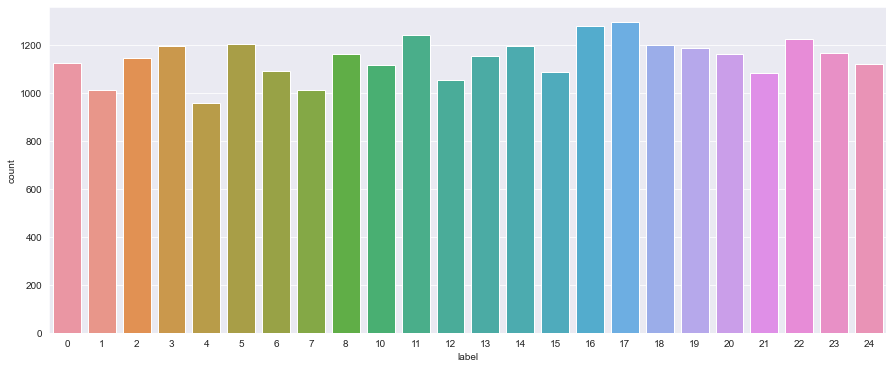

In [8]:
plt.figure(figsize=(15,6))
sns.set_style("darkgrid");
sns.countplot(y_train);

In [9]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

y_train[:2]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [10]:
def preprocess_image(x):
    
    x = x/255
    x = x.reshape(-1,28,28,1) 
    
    return x

In [11]:
train_x = preprocess_image(train_data.values)
test_x = preprocess_image(test_data.values)

In [12]:
def show_images(images,labels):
    fig,ax = plt.subplots(2,5)
    fig.set_size_inches(10, 6)
    k =0
    for i in range(2):
        for j in range(5):
            ax[i,j].imshow(images[k] , cmap='gray')
            ax[i,j].set_title(str(unique_labels[np.argmax(y_train[k])]))
            k = k+1;
    plt.tight_layout()

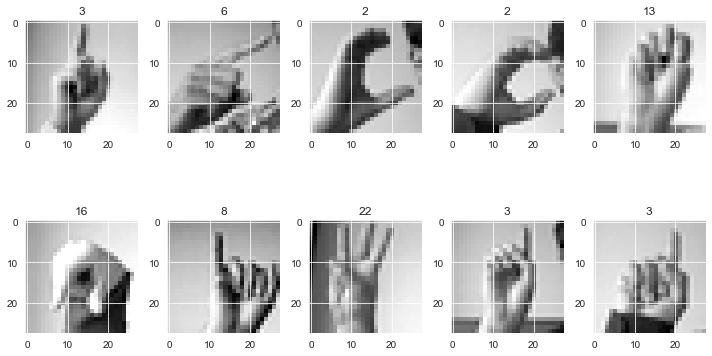

In [13]:
show_images(train_x,y_train)

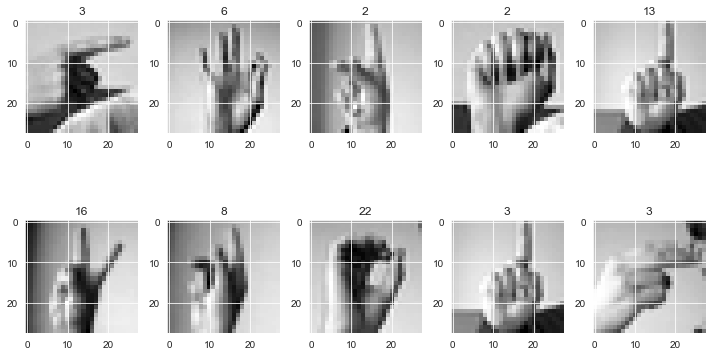

In [14]:
show_images(test_x,y_test)

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # mengatur rata-rata input menjadi 0 pada kumpulan data
        samplewise_center=False,  # mengatur setiap rata-rata sampel menjadi 0
        featurewise_std_normalization=False,  # membagi input dengan standard-deviation dari kumpulan data
        samplewise_std_normalization=False,  # membagi input dengan standard-deviationnya
        zca_whitening=False,  # mengaplikasikan ZCA whitening
        rotation_range=10,  # merotasi gambar secara random di derajat 0-180
        zoom_range = 0.1,  # mengcrop data
        width_shift_range=0.1,  # mengshift gambar secara horisontal
        height_shift_range=0.1,  # mengshift gambar secara vertikal
        horizontal_flip=False,  # memflip data secara horisontal
        vertical_flip=False)  # memflip data secara vertikal


datagen.fit(train_x)

In [16]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=75, max_value=200, step=25),
        kernel_size=(3,3),
        activation='relu',
        
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=50, max_value=125, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    
    keras.layers.Dropout(
        rate = hp.Choice('drop_1_rate', values = [0.1,0.5])
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    
    
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=25, max_value=75, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),  
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=1024, step=32),
        activation='relu'
    ),
    keras.layers.Dropout(
        rate = hp.Choice('drop_2_rate', values = [0.1,0.3])
    ),
    keras.layers.Dense(24, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [17]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="ASLdetection1")

INFO:tensorflow:Reloading Oracle from existing project output\ASLdetection1\oracle.json
INFO:tensorflow:Reloading Tuner from output\ASLdetection1\tuner0.json


In [18]:
tuner_search.search(train_x,y_train,epochs=5,validation_data = (test_x, y_test))


INFO:tensorflow:Oracle triggered exit


In [19]:
model=tuner_search.get_best_models(num_models=1)[0] 

In [20]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.5, min_lr=0.00001)

In [21]:
history = model.fit(datagen.flow(train_x,y_train, batch_size = 128) 
                    ,epochs = 20 # mengetest data sebanyak 20 kali
                    , validation_data = (test_x, y_test)
                    , callbacks = [lr_reduction])

Epoch 1/20
215/215 [==============================] - 75s 340ms/step - loss: 0.2162 - accuracy: 0.9315 - val_loss: 0.6303 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 72s 337ms/step - loss: 0.0436 - accuracy: 0.9861 - val_loss: 0.1013 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 74s 343ms/step - loss: 0.0221 - accuracy: 0.9931 - val_loss: 0.0380 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 77s 360ms/step - loss: 0.0148 - accuracy: 0.9958 - val_loss: 0.0112 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 74s 344ms/step - loss: 0.0141 - accuracy: 0.9953 - val_loss: 0.0416 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 74s 344ms/step - loss: 0.0170 - accuracy: 0.9940 - val_loss: 0.2470 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 7/20
215/215 [==============================] 

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 200)       2000      
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 200)      800       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 200)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 75)        135075    
                                                                 
 dropout (Dropout)           (None, 11, 11, 75)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 75)       3

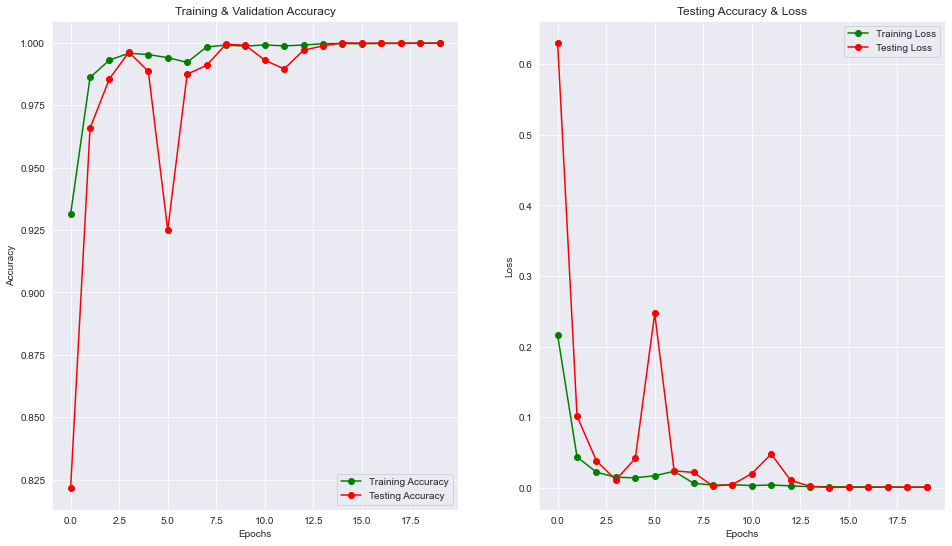

In [39]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

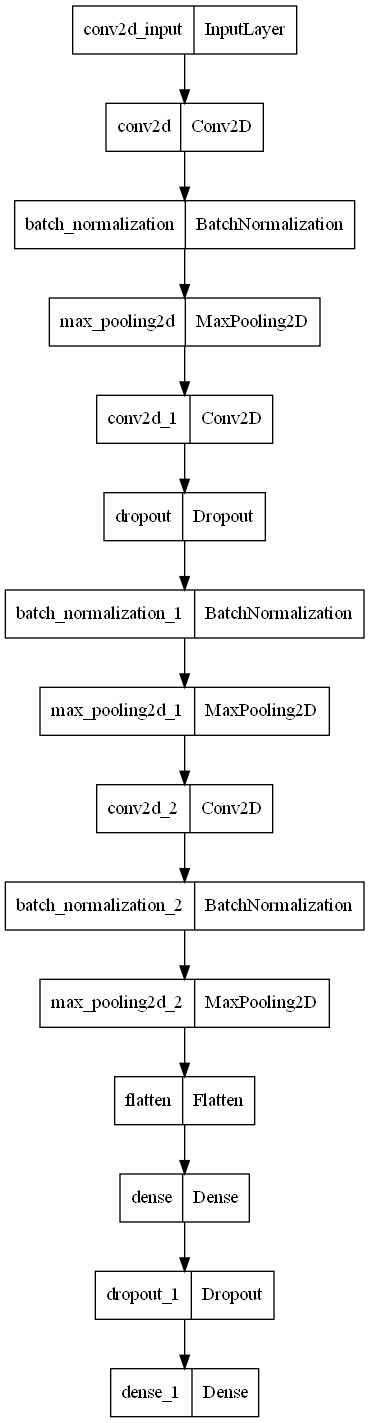

In [41]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [42]:
predictions = model.predict(test_x)


225/225 [==============================] - 7s 22ms/step


In [43]:
def predictions_to_labels(pred):
    labels =[]
    for p in pred:
        labels.append(unique_labels[np.argmax(p)])
    return labels

In [44]:
y_pred_labels = predictions_to_labels(predictions)
y_test_labels = predictions_to_labels(y_test)

In [47]:
a= accuracy_score(y_test_labels,y_pred_labels)
print("Current accuracy is {}%".format(a*100))

Current accuracy is 99.98605688789738%


<AxesSubplot: >

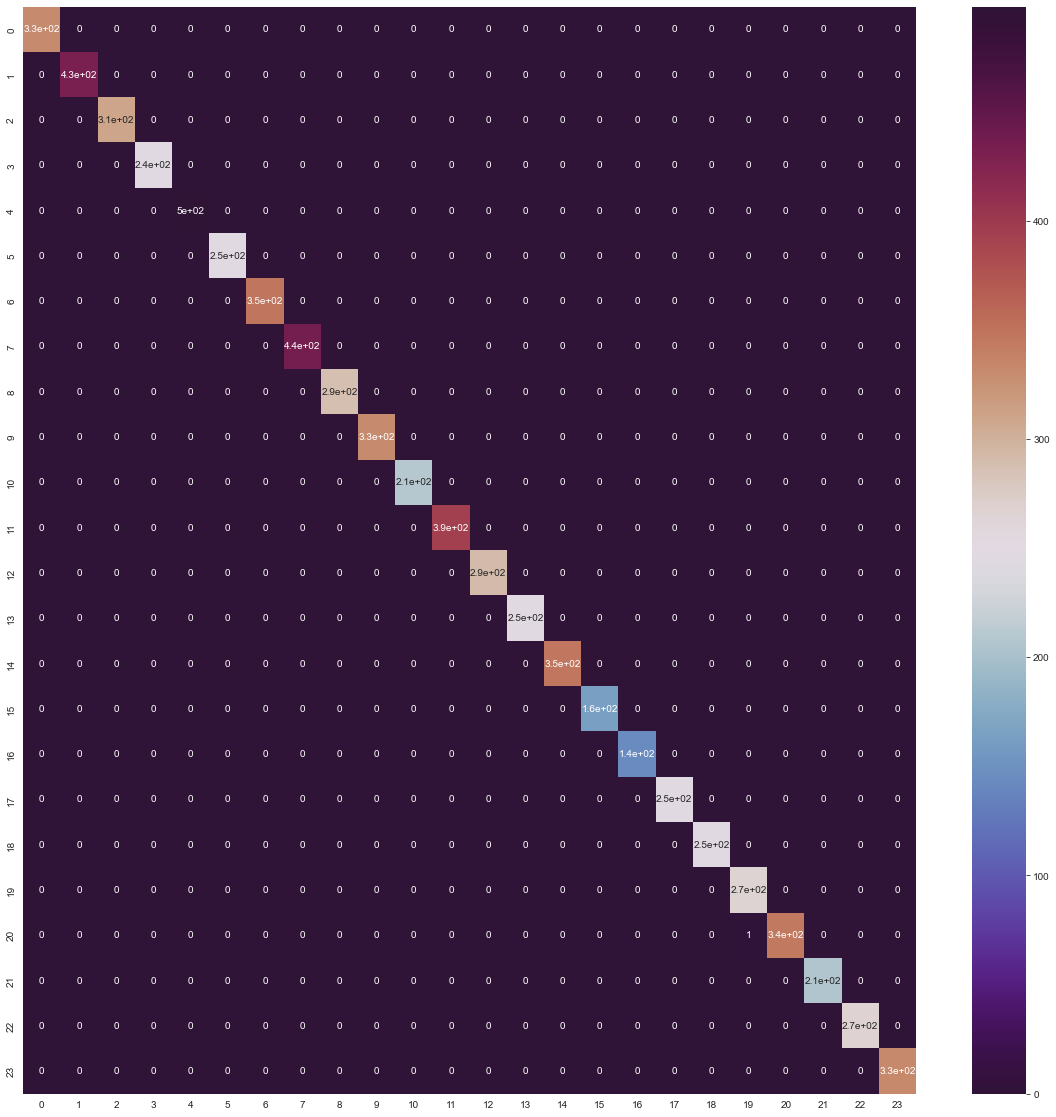

In [48]:
cm= confusion_matrix(y_test_labels,y_pred_labels)
plt.figure(figsize=(20,20))
sns.heatmap(cm,annot=True,cmap='twilight_shifted')